# load libraries

In [2]:
import setuptools.dist

In [3]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import csv
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display
import re
from tqdm.notebook import tqdm
import networkx as nx
import os
import shutil
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pickle
import faiss
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.manifold import TSNE
from contextlib import contextmanager
import sys
import codecs
from IPython.display import clear_output
import joblib
import gc

# get all images from exmple page

In [4]:
# URL of the webpage you want to scrape
url = 'https://www.stampworld.com/en/stamps/Germany/'

# Send HTTP request to the specified URL and save the response from server in a response object called r
r = requests.get(url)

# Create a BeautifulSoup object and specify the parser
soup = BeautifulSoup(r.text, 'html.parser')

# Find all the `<img>` tags in the HTML
img_tags = soup.find_all('img')

# Make the directory to save the images
os.makedirs('./images/data/', exist_ok=True)

for img in img_tags:
    img_url = img.get('src')
    # Check if the image URL starts with the specified URL
    if img_url.startswith('https://www.stampworld.com/media/catalogue/Germany/Postage-stamps/'):
        # Get the filename by splitting the URL on the slash and taking the last element
        filename = img_url.split('/')[-1]
        # Send a GET request to the image URL
        response = requests.get(img_url, stream=True)
        # Open the file in write mode and download the image
        with open('./images/data/' + filename, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)

# get most fitting image

In [2]:
# Load images
dir_path = './images/data/'
images = [cv2.imread(os.path.join(dir_path, file)) for file in os.listdir(dir_path)]

# Initialize feature extractor
sift = cv2.SIFT_create()

# Extract features from all images
descriptors = []
for image in images:
    if image is None:
        print('Failed to load image file.')
    _, desc = sift.detectAndCompute(image, None)
    # Compute a representative descriptor by averaging all descriptors of an image
    avg_desc = np.mean(desc, axis=0)
    descriptors.append(avg_desc)

# Fit a nearest neighbors model to the descriptors
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(descriptors)

# Now, given a new image, we can find the most similar image in the database
new_image = cv2.imread('./images/test/0047-b-2.jpg')
_, new_desc = sift.detectAndCompute(new_image, None)
# Compute a representative descriptor for the new image
new_avg_desc = np.mean(new_desc, axis=0)

distances, indices = nn.kneighbors([new_avg_desc])

# The index of the most similar image in the database is
most_similar_image_index = indices[0][0]

most_similar_image = images[most_similar_image_index]

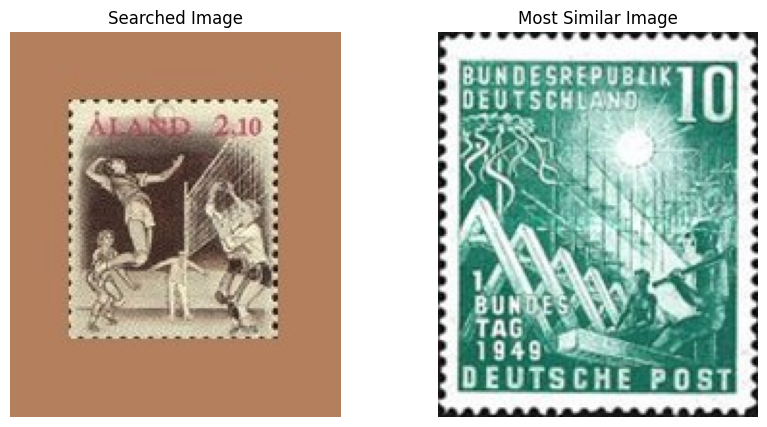

In [3]:
# Display the most similar image

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
plt.title('Searched Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(most_similar_image, cv2.COLOR_BGR2RGB))
plt.title('Most Similar Image')
plt.axis('off')

plt.show()

# Feature extraction

## extract features from all reference images

In [11]:
# Load images
dir_path = './images/data/'
image_files = [file for file in os.listdir(dir_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
images = [cv2.imread(os.path.join(dir_path, file)) for file in image_files]

# Initialize feature extractor
sift = cv2.SIFT_create()

# Extract features from all images
keypoints_list = []
descriptors_list = []
for image in images:
    if image is None:
        print('Failed to load image file.')
        continue
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
        keypoints_list.append([(kp.pt[0], kp.pt[1], kp.size) for kp in keypoints])  # Save keypoints as list of tuples with size
        descriptors_list.append(descriptors)
    else:
        keypoints_list.append([])
        descriptors_list.append([])

# Save keypoints and descriptors
with open('features.pkl', 'wb') as f:
    pickle.dump((keypoints_list, descriptors_list), f)

print("Features saved successfully.")

Features saved successfully.


### for actual stamp images

In [20]:
# Load images
dir_path = '../crawling/images/'
# Get all images in subdirectories
image_files = []
for root, dirs, files in os.walk(dir_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_files.append(os.path.join(root, file))

images = [cv2.imread(file) for file in image_files]

# Initialize feature extractor
sift = cv2.SIFT_create()

# Extract features from all images
keypoints_list = []
descriptors_list = []

for image in tqdm(images):
    if image is None:
        print('Failed to load image file.')
        continue
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
        keypoints_list.append([(kp.pt[0], kp.pt[1], kp.size) for kp in keypoints])  # Save keypoints as list of tuples with size
        descriptors_list.append(descriptors)
    else:
        keypoints_list.append([])
        descriptors_list.append([])

# Save keypoints, descriptors, and file paths
with open('features_2.pkl', 'wb') as f:
    pickle.dump((image_files, keypoints_list, descriptors_list), f)

print("Features saved successfully.")

  0%|          | 0/11688 [00:00<?, ?it/s]

Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
Failed to load image file.
F

## compare to new image

In [18]:
# Load previously saved features
with open('features.pkl', 'rb') as f:
    keypoints_list, descriptors_list = pickle.load(f)

# Initialize SIFT feature extractor and FLANN-based matcher
sift = cv2.SIFT_create()
flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict())

# Load and process the new image
new_image_path = './images/test/A1-s-2.jpg'
# new_image_path = './images/test/0047-b-2.jpg'
new_image = cv2.imread(new_image_path)
if new_image is None:
    print('Failed to load the new image.')
else:
    # Extract keypoints and descriptors from the new image
    new_keypoints, new_descriptors = sift.detectAndCompute(new_image, None)

    if new_descriptors is None:
        print('No descriptors found in the new image.')
    else:
        # Function to find the best match for the new image using FLANN
        def find_best_match(new_descriptors, descriptors_list):
            best_match_index = -1
            best_match_score = 0  # Change to 0 for counting matches
            
            for i, descriptors in enumerate(descriptors_list):
                if descriptors is not None and new_descriptors is not None:
                    # Find matches between new descriptors and reference descriptors
                    matches = flann.knnMatch(new_descriptors, descriptors, k=2)

                    # Apply ratio test with a more lenient threshold
                    good_matches = [m for m, n in matches if m.distance < 0.8 * n.distance]

                    # Score based on the number of good matches
                    match_score = len(good_matches)

                    # Update best match if current match score is better
                    if match_score > best_match_score:
                        best_match_score = match_score
                        best_match_index = i

            return best_match_index, best_match_score

        # Find the most similar image
        best_match_index, best_match_score = find_best_match(new_descriptors, descriptors_list)

        if best_match_index != -1:
            image_files = [file for file in os.listdir('./images/data/') if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            best_image_path = os.path.join('./images/data/', image_files[best_match_index])

            # best_image = cv2.imread(best_image_path)

            # # Extract keypoints and descriptors from the best matching image
            # best_image_keypoints, best_image_descriptors = sift.detectAndCompute(best_image, None)

            # if best_image_keypoints is not None and best_image_descriptors is not None:
            #     # Find matches between new image and best matching image
            #     matches = flann.knnMatch(new_descriptors, best_image_descriptors, k=2)

            #     # Apply ratio test to filter matches
            #     good_matches = [m for m, n in matches if m.distance < 0.8 * n.distance]

            #     # Draw matches
            #     img_matches = cv2.drawMatches(new_image, new_keypoints, best_image, best_image_keypoints, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

            #     # Show the result
            #     cv2.imshow('Matches', img_matches)
            #     cv2.waitKey(0)
            #     cv2.destroyAllWindows()

            print(f"The most similar image is {best_image_path} with a score of {best_match_score}.")
        else:
            print("No match found.")

The most similar image is ./images/data/A1-s.jpg with a score of 286.


### for the actual stamps

In [21]:
# Load previously saved features
with open('features_2.pkl', 'rb') as f:
    image_files, keypoints_list, descriptors_list = pickle.load(f)

# Initialize SIFT feature extractor and FLANN-based matcher
sift = cv2.SIFT_create()
flann_params = dict(algorithm=1, trees=5)  # FLANN with KD-Trees
search_params = dict(checks=50)  # Number of checks (traversals) per tree
flann = cv2.FlannBasedMatcher(flann_params, search_params)

# Load and process the new image
new_image_path = './images/test/29.jpg'
new_image = cv2.imread(new_image_path)
if new_image is None:
    print('Failed to load the new image.')
else:
    # Extract keypoints and descriptors from the new image
    new_keypoints, new_descriptors = sift.detectAndCompute(new_image, None)

    if new_descriptors is None:
        print('No descriptors found in the new image.')
    else:
        # Function to find the best match for the new image using FLANN
        def find_best_match(new_descriptors, descriptors_list):
            best_match_index = -1
            best_match_score = 0  # Change to 0 for counting matches
            best_match_keypoints = None
            best_match_descriptors = None
            
            for i, descriptors in enumerate(descriptors_list):
                if descriptors is not None and new_descriptors is not None:
                    # Find matches between new descriptors and reference descriptors
                    matches = flann.knnMatch(new_descriptors, descriptors, k=2)

                    # Apply ratio test with a more lenient threshold
                    good_matches = [m for m, n in matches if m.distance < 0.8 * n.distance]

                    # Score based on the number of good matches
                    match_score = len(good_matches)

                    # Update best match if current match score is better
                    if match_score > best_match_score:
                        best_match_score = match_score
                        best_match_index = i
                        best_match_keypoints = keypoints_list[i]
                        best_match_descriptors = descriptors

            return best_match_index, best_match_score, best_match_keypoints, best_match_descriptors

        # Find the most similar image
        best_match_index, best_match_score, best_match_keypoints, best_match_descriptors = find_best_match(new_descriptors, descriptors_list)

        if best_match_index != -1:
            best_image_path = image_files[best_match_index]

            best_image = cv2.imread(best_image_path)

            # Extract keypoints and descriptors from the best matching image
            best_image_keypoints, best_image_descriptors = sift.detectAndCompute(best_image, None)

            if best_image_keypoints is not None and best_image_descriptors is not None:
                # Find matches between new image and best matching image
                matches = flann.knnMatch(new_descriptors, best_image_descriptors, k=2)

                # Apply ratio test to filter matches
                good_matches = [m for m, n in matches if m.distance < 0.8 * n.distance]

                # Draw matches
                img_matches = cv2.drawMatches(new_image, new_keypoints, best_image, best_image_keypoints, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

                # Show the result
                cv2.imshow('Matches', img_matches)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

                print(f"The most similar image is {best_image_path} with a score of {best_match_score}.")
            else:
                print('Failed to extract keypoints or descriptors from the best matching image.')
        else:
            print("No match found.")


The most similar image is ../crawling/images/Aaland\8980\25.jpg with a score of 306.


# Version 2

In [33]:
def load_image(image_path):
    """ Load an image from a file path. """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Image not found at {image_path}")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def preprocess_image(image, size=(128, 128)):
    """ Resize and flatten the image. """
    image = cv2.resize(image, size)
    return image.flatten()

def extract_features(image):
    """ Extract features from an image. """
    return preprocess_image(image)

def compare_images(img1, img2):
    """ Compare two images using cosine similarity. """
    features1 = extract_features(img1)
    features2 = extract_features(img2)
    return cosine_similarity([features1], [features2])[0][0]

def find_best_match(reference_image_path, images_directory):
    """ Find the best matching image in a directory. """
    best_match = None
    best_score = -1
    
    reference_image = load_image(reference_image_path)
    for root, _, files in os.walk(images_directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                try:
                    image = load_image(image_path)
                    score = compare_images(reference_image, image)
                    if score > best_score:
                        best_score = score
                        best_match = image_path
                except ValueError as e:
                    print(e)
    
    return best_match, best_score

In [36]:
# Example usage
reference_image_path = './images/test/29.jpg'
images_directory = '../crawling/images/'

best_match, best_score = find_best_match(reference_image_path, images_directory)
print(f"Best match: {best_match} with score: {best_score}")

Best match: ../crawling/images/Aaland\5620\29.jpg with score: 0.9975237294178916


# Version 3: deep learning

In [28]:
# Configure TensorFlow to suppress verbose output
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow info and warning messages

# Load the pre-trained ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

In [33]:
def get_image_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    embedding = model.predict(x, verbose=0)
    return embedding

def merge_pkl_files(output_file, batch_files):
    merged_data = {}
    for batch_file in batch_files:
        with open(batch_file, 'rb') as f:
            data = joblib.load(f)
            merged_data.update(data)
        # os.remove(batch_file)  # Remove the batch file after merging
    with open(output_file, 'wb') as f:
        joblib.dump(merged_data, f)

In [32]:
# # Compute embeddings for all images in the database
# database_embeddings = {}
# counter = 0
# for root, dirs, files in os.walk('../crawling/images_all/'):
#     for file in files:
#         if file.endswith(('.jpg', '.png')):  # add more extensions if needed
#             img_path = os.path.join(root, file)
#             print(f'Processing image {counter}: {img_path}')
#             database_embeddings[img_path] = get_image_embedding(img_path)
#             clear_output(wait=True)
#             counter += 1

# # Save embeddings to a file
# with open('database_embeddings_all.pkl', 'wb') as f:
#     pickle.dump(database_embeddings, f)

# batch_size = 1000
# database_embeddings = {}
# counter = 0
# batch_counter = 0
# batch_files = []

# for root, dirs, files in os.walk('../crawling/images_all/'):
#     for file in files:
#         if file.endswith(('.jpg', '.png')):  # add more extensions if needed
#             img_path = os.path.join(root, file)
#             print(f'Processing image {counter}: {img_path}')
#             database_embeddings[img_path] = get_image_embedding(img_path)
#             clear_output(wait=True)
#             counter += 1

#             if counter % batch_size == 0:
#                 # Save the current batch to disk
#                 batch_file = f'database_embeddings_batch_{batch_counter}.pkl'
#                 with open(batch_file, 'wb') as f:
#                     joblib.dump(database_embeddings, f)
#                 batch_files.append(batch_file)
#                 database_embeddings = {}
#                 batch_counter += 1

#                 # Merge batch files periodically
#                 if len(batch_files) >= 10:  # Adjust the number as needed
#                     merge_pkl_files('database_embeddings_all.pkl', batch_files)
#                     batch_files = []

# # Save any remaining embeddings
# if database_embeddings:
#     batch_file = f'database_embeddings_batch_{batch_counter}.pkl'
#     with open(batch_file, 'wb') as f:
#         joblib.dump(database_embeddings, f)
#     batch_files.append(batch_file)

# # Merge any remaining batch files
# if batch_files:
#     merge_pkl_files('database_embeddings_all.pkl', batch_files)

# Directory to save batch files
batch_dir = './embeddings/'
os.makedirs(batch_dir, exist_ok=True)

batch_size = 1000
database_embeddings = {}
counter = 0
batch_counter = 0

for root, dirs, files in os.walk('../crawling/images_all/'):
    for file in files:
        if file.endswith(('.jpg', '.png')):  # Add more extensions if needed
            img_path = os.path.join(root, file)
            database_embeddings[img_path] = get_image_embedding(img_path)
            counter += 1

            if counter % batch_size == 0:
                # Save the current batch to disk
                batch_file = os.path.join(batch_dir, f'database_embeddings_batch_{batch_counter}.pkl')
                with open(batch_file, 'wb') as f:
                    joblib.dump(database_embeddings, f)

                sys.stdout.flush()

                # Print which batch is currently processed
                print(f'Saved batch {batch_counter} with {batch_size} images.')
                
                # Clear variables and force garbage collection
                del database_embeddings
                database_embeddings = {}
                gc.collect()
                
                batch_counter += 1

# Save any remaining embeddings
if database_embeddings:
    batch_file = os.path.join(batch_dir, f'database_embeddings_batch_{batch_counter}.pkl')
    with open(batch_file, 'wb') as f:
        joblib.dump(database_embeddings, f)
    
    # Clear variables and force garbage collection
    del database_embeddings
    gc.collect()

Saved batch 0 with 1000 images.
Saved batch 1 with 1000 images.
Saved batch 2 with 1000 images.
Saved batch 3 with 1000 images.
Saved batch 4 with 1000 images.
Saved batch 5 with 1000 images.
Saved batch 6 with 1000 images.
Saved batch 7 with 1000 images.
Saved batch 8 with 1000 images.
Saved batch 9 with 1000 images.
Saved batch 10 with 1000 images.
Saved batch 11 with 1000 images.
Saved batch 12 with 1000 images.
Saved batch 13 with 1000 images.
Saved batch 14 with 1000 images.
Saved batch 15 with 1000 images.
Saved batch 16 with 1000 images.
Saved batch 17 with 1000 images.
Saved batch 18 with 1000 images.
Saved batch 19 with 1000 images.
Saved batch 20 with 1000 images.
Saved batch 21 with 1000 images.
Saved batch 22 with 1000 images.
Saved batch 23 with 1000 images.
Saved batch 24 with 1000 images.
Saved batch 25 with 1000 images.
Saved batch 26 with 1000 images.
Saved batch 27 with 1000 images.
Saved batch 28 with 1000 images.
Saved batch 29 with 1000 images.
Saved batch 30 with 

In [34]:
# merge all pkl files
output_file = 'database_embeddings_all.pkl'
batch_files = [os.path.join(batch_dir, file) for file in os.listdir(batch_dir)]
merge_pkl_files(output_file, batch_files)

## try to identify new image

In [7]:
# Load embeddings from a file
# with open('database_embeddings.pkl', 'rb') as f:
#     database_embeddings = pickle.load(f)

# with open('database_embeddings_all.pkl', 'rb') as f:
#     database_embeddings = joblib.load(f)

# # Dimension of our vector space
# d = 2048

# # Convert our database embeddings to a matrix
# db_matrix = np.vstack(list(database_embeddings.values()))

# # Normalize the vectors
# db_matrix /= np.linalg.norm(db_matrix, axis=1)[:, np.newaxis]

# # Build the FAISS index
# index = faiss.IndexFlatL2(d)
# index.add(db_matrix)

with open('database_embeddings_all.pkl', 'rb') as f:
    database_embeddings = joblib.load(f)

# Convert the embeddings to a matrix for easier distance computation
db_matrix = np.vstack(list(database_embeddings.values()))

db_matrix /= np.linalg.norm(db_matrix, axis=1)[:, np.newaxis]

model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def get_image_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    embedding = model.predict(x, verbose=0)
    return embedding

def find_closest_images(input_embedding, database_embeddings, db_matrix, top_k=10):
    # Normalize the input embedding
    input_embedding = input_embedding.flatten()
    input_embedding /= np.linalg.norm(input_embedding)
    
    # Compute the distances (using Euclidean distance)
    distances = np.linalg.norm(db_matrix - input_embedding, axis=1)
    
    # Find the indices of the top_k closest embeddings
    closest_indices = np.argsort(distances)[:top_k]
    
    # Get the paths of the closest images
    closest_images = [list(database_embeddings.keys())[i] for i in closest_indices]
    
    return closest_images

def find_closest_images_approx(input_embedding, database_embeddings, db_matrix, top_k=10):
    # Normalize the input embedding
    input_embedding = input_embedding.flatten()
    input_embedding /= np.linalg.norm(input_embedding)

    # Use NearestNeighbors to find approximate nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=top_k, algorithm='auto').fit(db_matrix)
    distances, indices = nbrs.kneighbors([input_embedding])

    # Get the paths of the closest images
    closest_images = [list(database_embeddings.keys())[i] for i in indices[0]]

    return closest_images

In [16]:
# Now you can compare an input image to all images in the database
# input_img_path = '../crawling/images/Albania/25458/25.jpg'
# input_img_path = './images/test/29.jpg'
# input_img_path = './images/test/A1-s-2.jpg'
# input_embedding = get_image_embedding(input_img_path)

# # Normalize the input vector
# input_embedding = input_embedding.flatten()
# input_embedding /= np.linalg.norm(input_embedding)

# # Get the indices of the 5 nearest neighbors of the input image
# D, I = index.search(np.array([input_embedding]), 10)

# # Print the paths of the 5 most similar images
# for i in I[0]:
#     print(list(database_embeddings.keys())[i])

input_img_path = './images/test/29.jpg'

input_embedding = get_image_embedding(input_img_path)

closest_images = find_closest_images_approx(input_embedding, database_embeddings, db_matrix, top_k=5)

# Display the paths of the closest images
for img_path in closest_images:
    print(img_path)

../crawling/images_all/South Korea\115546\GR1-s.jpg
../crawling/images_all/Fezzan\92497\Q2-s.jpg
../crawling/images_all/Libya\169229\DI-s.jpg
../crawling/images_all/Austro Hungary Military Post\67384\A14-s.jpg
../crawling/images_all/Brazil\47097\AGD-s.jpg


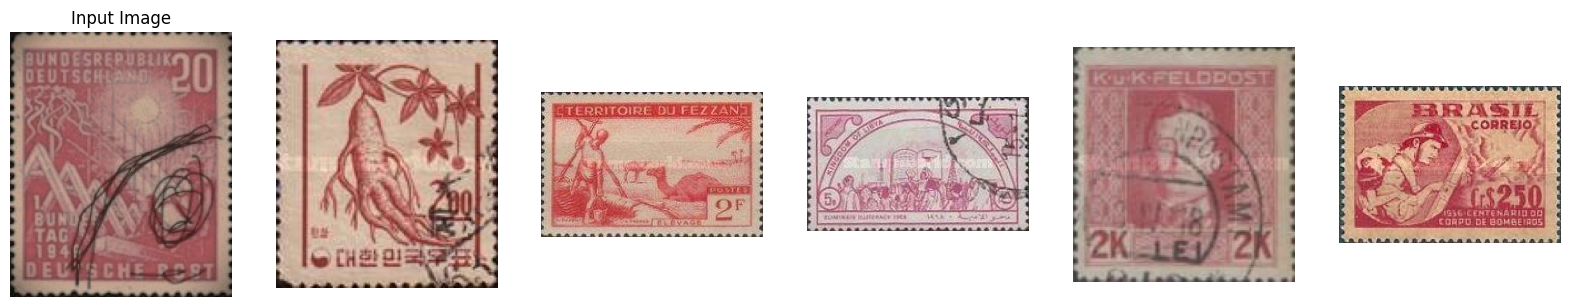

In [17]:
# Load the input image
input_img = Image.open(input_img_path)

# Get the paths of the 10 most similar images and their scores
# similar_images = [list(database_embeddings.keys())[i] for i in I[0]]
# similar_scores = D[0]

similar_images = closest_images

# Plot the input image and each similar image along with its score
plt.figure(figsize=(20, 20))

# Plot the input image
plt.subplot(1, len(similar_images) + 1, 1)
plt.imshow(input_img)
plt.title('Input Image')
plt.axis('off')

# Plot each similar image
for i, img_path in enumerate(similar_images):
    img = Image.open(img_path)
    plt.subplot(1, len(similar_images) + 1, i + 2)
    plt.imshow(img)
    # plt.title(f'Score: {similar_scores[i]:.2f}')
    plt.axis('off')

plt.show()

# finding errors

In [54]:
len(database_embeddings)
index

<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x0000023A2B8BBF60> >

In [21]:
# Load the model (ensure it's the same model used to generate embeddings)
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def get_image_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    embedding = model.predict(x)
    return embedding

def load_embeddings(embedding_file):
    with open(embedding_file, 'rb') as f:
        return joblib.load(f)

# Load all database embeddings
database_embeddings = load_embeddings('database_embeddings_all.pkl')

# Get the embedding for the query image
query_image_path = './images/test/01.jpg'
query_embedding = get_image_embedding(query_image_path)

# Flatten the query embedding for similarity computation
query_embedding = query_embedding.flatten()

# Prepare the database embeddings for similarity computation
db_image_paths = list(database_embeddings.keys())
db_embeddings = np.array([embedding.flatten() for embedding in database_embeddings.values()])

# Calculate cosine similarities
similarities = cosine_similarity(query_embedding.reshape(1, -1), db_embeddings).flatten()

# Get the indices of the top 10 most similar images
top_indices = np.argsort(similarities)[-10:]

# Retrieve the file paths of the most similar images
most_similar_images = [(db_image_paths[i], similarities[i]) for i in top_indices]

# Print the results
for img_path, sim in most_similar_images:
    print(f'Image: {img_path}, Similarity: {sim}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image: ../crawling/images_all/Zambia\102153\LP-s.jpg, Similarity: 0.8151576519012451
Image: ../crawling/images_all/Yugoslavia\55093\CGU-s.jpg, Similarity: 0.8161523342132568
Image: ../crawling/images_all/Zanzibar\154997\AP-s.jpg, Similarity: 0.8216009140014648
Image: ../crawling/images_all/Yugoslavia\209429\I-s.jpg, Similarity: 0.8221482634544373
Image: ../crawling/images_all/Zanzibar\155002\AZ-s.jpg, Similarity: 0.8270467519760132
Image: ../crawling/images_all/Yugoslavia\55540\CVA-s.jpg, Similarity: 0.8272354602813721
Image: ../crawling/images_all/Zambezia\96928\E2-s.jpg, Similarity: 0.8281466960906982
Image: ../crawling/images_all/Zanzibar\155015\EH1-s.jpg, Similarity: 0.8283305168151855
Image: ../crawling/images_all/Zanzibar\155002\AZ2-s.jpg, Similarity: 0.8314542174339294
Image: ../crawling/images_all/Zanzibar\155002\AZ3-s.jpg, Similarity: 0.8396346569061279


In [18]:
def compute_similarity(embedding1, embedding2):
    return cosine_similarity(embedding1, embedding2)

# Load embeddings
with open('database_embeddings_all.pkl', 'rb') as f:
    loaded_embeddings = joblib.load(f)

# Compute similarity
query_embedding = get_image_embedding('./images/test/29.jpg')
scores = {}
for img_path, embedding in loaded_embeddings.items():
    score = compute_similarity(query_embedding, embedding)
    scores[img_path] = score
    # print(f'Score for {img_path}: {score}')

# print lowest score
min_score = min(scores.values())
min_score_path = [path for path, score in scores.items() if score == min_score]
print(f'Lowest score: {min_score} for image {min_score_path}')

# print highest score
max_score = max(scores.values())
max_score_path = [path for path, score in scores.items() if score == max_score]
print(f'Highest score: {max_score} for image {max_score_path}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Lowest score: [[0.21920332]] for image ['../crawling/images_all/Yugoslavia\\55822\\3063-b.jpg']
Highest score: [[0.82605875]] for image ['../crawling/images_all/Zanzibar\\155010\\DN-s.jpg']


In [4]:
def load_embeddings(embedding_file):
    with open(embedding_file, 'rb') as f:
        return joblib.load(f)

database_embeddings = load_embeddings('database_embeddings_all.pkl')

# print storage space of database embeddings
import sys
print(sys.getsizeof(database_embeddings))

15379200


: 